In [1]:
import os
import numpy as np


In [2]:
from tensorflow.keras.preprocessing import image

# Dataset source: https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = image.load_img(img_path, target_size=target_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

2025-02-27 22:10:29.904959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740669029.916407   19952 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740669029.919841   19952 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 22:10:29.932964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Чтение датасета
train_dir = 'datasets/faces/images/train'
X_train, y_train = load_images_from_directory(train_dir)
test_dir = 'datasets/faces/images/test'
X_test, y_test = load_images_from_directory(test_dir)
val_dir = 'datasets/faces/images/val'
X_val, y_val = load_images_from_directory(val_dir)

In [4]:
# Объединение датасета
X = np.concatenate([X_train, X_val, X_test])
y = np.concatenate([y_train, y_val, y_test])
X.shape, y.shape

((394, 224, 224, 3), (394,))

In [5]:
# Создание датасета содержащего все классы, кроме <excluded_class>
excluded_class = 'chris_hemsworth'
mask_excluded = (y != excluded_class)
X_excluded, y_excluded = X[mask_excluded], y[mask_excluded]
X_excluded.shape, y_excluded.shape

((317, 224, 224, 3), (317,))

In [6]:
import matplotlib.pyplot as plt

# Изображение <idx> и его класс

# idx = 300
# plt.imshow(X[idx].astype('uint8'))
# plt.axis('off')
# plt.show()
# y[idx]

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

X = preprocess_input(X)

# Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_excluded_train, X_excluded_test, y_excluded_train, y_excluded_test = train_test_split(X_excluded, y_excluded, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.applications import ResNet50

# Создание предобученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

I0000 00:00:1740669032.856630   19952 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5656 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [9]:
# Вычисление признаков для обучающей выборки
train_features = base_model.predict(X_train)
# Вычисление признаков для тестовой выборки
test_features = base_model.predict(X_test)


# Вычисление признаков для обучающей выборки (без 1 класса)
train_excluded_features = base_model.predict(X_excluded_train)
# Вычисление признаков для тестовой выборки (без 1 класса)
test_excluded_features = base_model.predict(X_excluded_test)

I0000 00:00:1740669035.220743   20031 service.cc:148] XLA service 0x72fa8c149f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740669035.220772   20031 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 22:10:35.274514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740669035.540097   20031 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-27 22:10:38.178631: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

I0000 00:00:1740669038.563999   20031 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [10]:
# Отображение примера признаков, их размерности
train_excluded_features[0].shape, train_excluded_features

((2048,),
 array([[4.5562861e-03, 2.1946084e+00, 0.0000000e+00, ..., 5.8642771e-02,
         0.0000000e+00, 1.7852776e-01],
        [3.7668213e-01, 1.6164553e+00, 3.2252693e-01, ..., 0.0000000e+00,
         1.9718918e-03, 3.0024764e-01],
        [1.8538158e-01, 1.7917527e+00, 0.0000000e+00, ..., 3.4435934e-01,
         1.2079002e-02, 3.0201381e-01],
        ...,
        [2.7053475e-01, 3.9971751e-01, 0.0000000e+00, ..., 9.6749705e-01,
         1.4015807e-01, 1.2932110e-01],
        [7.3561400e-02, 7.9533601e-01, 0.0000000e+00, ..., 0.0000000e+00,
         4.1788054e-01, 1.8010910e-01],
        [4.8489375e-03, 7.2205991e-01, 0.0000000e+00, ..., 3.8592178e-01,
         3.0936908e-02, 3.8640112e-01]], dtype=float32))

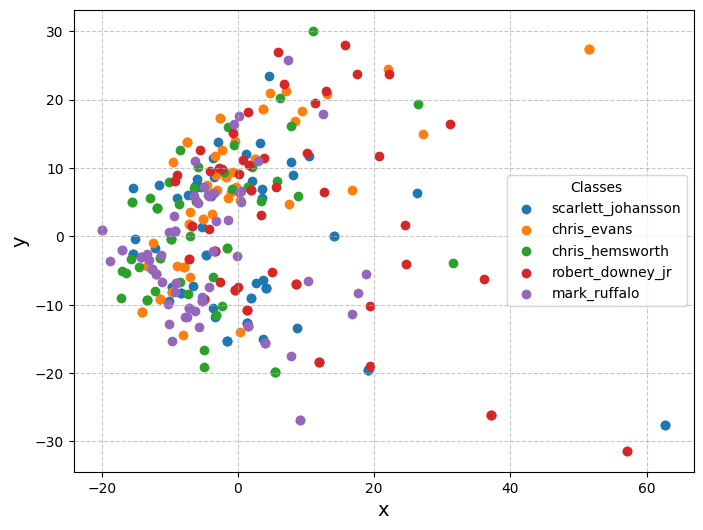

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Понижение размерности для визуализации

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for class_name in set(y_train):
    plt.scatter(X_pca[y_train == class_name, 0], X_pca[y_train == class_name, 1], label=class_name)


plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(title='Classes')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

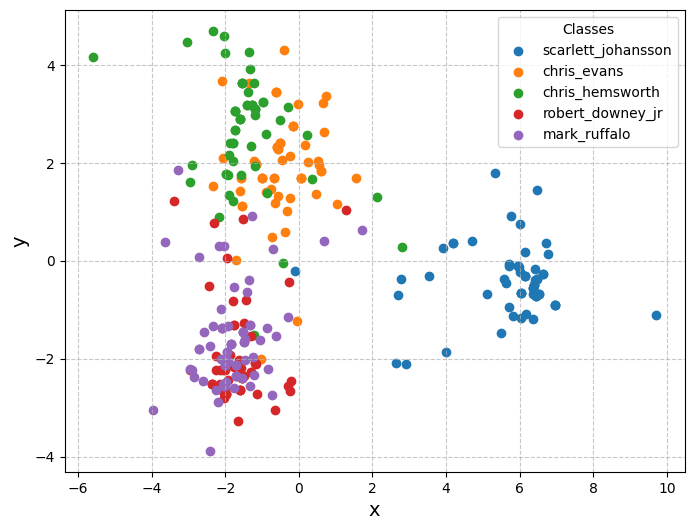

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Понижение размерности для визуализации

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_train)

X_test_scaled = scaler.transform(test_features)
X_test_lda = lda.transform(X_test_scaled)


plt.figure(figsize=(8, 6))
for class_name in set(y_train):
    plt.scatter(X_lda[y_train == class_name, 0], X_lda[y_train == class_name, 1], label=class_name)


plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(title='Classes')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# KNN модель обученная на полной выборке
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(train_features, y_train)

# KNN модель обученная на выборке без 1 класса
knn_excluded = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_excluded.fit(train_excluded_features, y_excluded_train)

# KNN модель обученная на 2 признаках (полученных после понижения размерности)
knn_lda = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_lda.fit(X_lda, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [14]:
# Предсказание модели для полной выборки
y_pred = knn.predict(test_features)

# Предсказание модели для выборки без 1 класса
y_excluded_pred = knn_excluded.predict(test_excluded_features)

# Предсказание модели для выборки из 2 признаков
y_lda_pred = knn_lda.predict(X_test_lda)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.cm as cm

# Отображение метрик для предсказания
def get_metrics(y_t, y_p):
    accuracy = accuracy_score(y_t, y_p)
    precision = precision_score(y_t, y_p, average='weighted')
    recall = recall_score(y_t, y_p, average='weighted')
    f1_micro = f1_score(y_t, y_p, average='micro')
    f1_macro = f1_score(y_t, y_p, average='macro')

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-micro', 'F1-macro']
    values = [accuracy, precision, recall, f1_micro, f1_macro]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=cm.rainbow(np.linspace(0, 1, len(metrics))))

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    return plt

<module 'matplotlib.pyplot' from '/home/igor/miniconda3/envs/tf_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

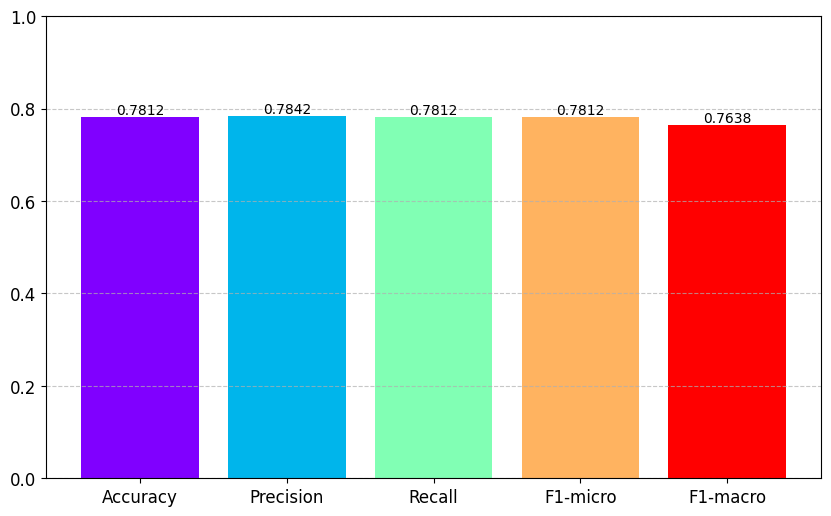

In [16]:
get_metrics(y_excluded_test, y_excluded_pred)

<module 'matplotlib.pyplot' from '/home/igor/miniconda3/envs/tf_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

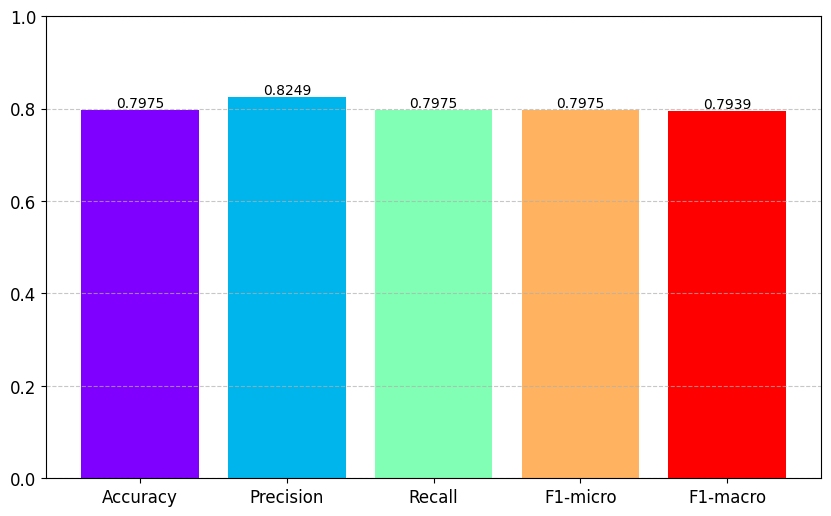

In [17]:
get_metrics(y_test, y_pred)

<module 'matplotlib.pyplot' from '/home/igor/miniconda3/envs/tf_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

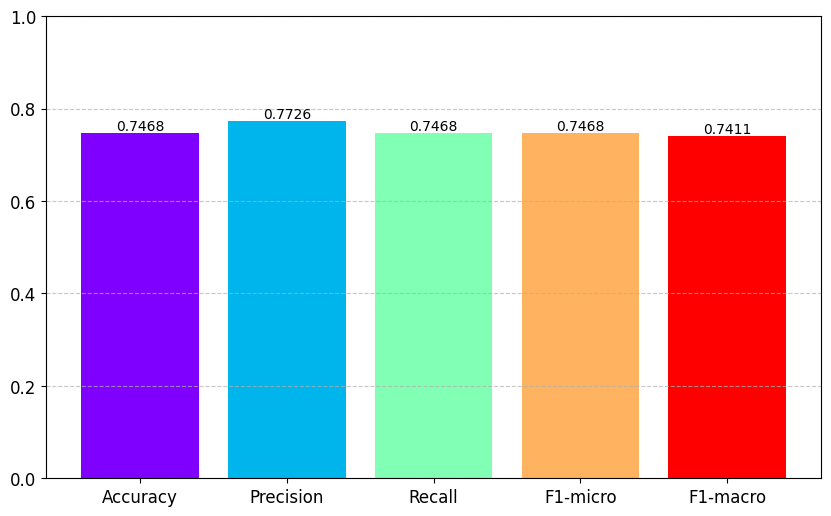

In [18]:
get_metrics(y_test, y_lda_pred)